#### *Run this cell to resolve import issues*

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from log_parser import parse_keyboard_log
from log_parser import parse_mouse_log
from keyboard_heatmap import KeyboardHeatmap

# Segment length of each data sample
train_seg_length = 100
test_seg_length = 100

routing_file = open('../.routing', 'r')
Lines = routing_file.readlines()

# List of parsed logfiles
keyboard = []
mouse = []

for line in Lines:
    line = line.strip()
    if 'key.log' in line:
        keyboard.append(parse_keyboard_log('../' + line))
    elif 'mouse.log' in line:
        mouse.append(parse_mouse_log('../' + line))

# Split into train and test sets
X_train = []
X_test = []
Y_train = []
Y_test = []

for k in range(len(keyboard) - 1):
    for i in range(int(keyboard[k].time.iloc[-1] / train_seg_length)):
        # For each segment in each logfile
        # Create a heatmap for that segment
        heatmap = KeyboardHeatmap(keyboard[k], i, train_seg_length)
        heatmap = heatmap.to_binary_class_label("MITSOL")
        # If the heatmap isn't blank
        if heatmap.class_label() != 'Null':
            X_train.append(heatmap.heatmap_data().ravel().tolist())
            Y_train.append(heatmap.class_label())

for k in range(len(keyboard) - 1,len(keyboard)):
    for i in range(int(keyboard[k].time.iloc[-1] / test_seg_length)):
        # For each segment in each logfile
        # Create a heatmap for that segment
        heatmap = KeyboardHeatmap(keyboard[k], i, test_seg_length)
        heatmap = heatmap.to_binary_class_label("MITSOL")
        # If the heatmap isn't blank
        if heatmap.class_label() != 'Null':
            X_test.append(heatmap.heatmap_data().ravel().tolist())
            Y_test.append(heatmap.class_label())

print(f"Train samples: {len(Y_train)}")
print(f"Test samples: {len(Y_test)}")

Train samples: 424
Test samples: 35


In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# Create random forests classifier object
# n_jobs controls multithreading, -1 uses all available threads
# criterion determines how well a feature splits data, we use gini
# max_features determines the number of candidate features available for a best split
# n_estimators determines the number of trees in our forest
# oob_score determines whether or not our forest uses out of bag error
rfc = RandomForestClassifier(n_jobs=-1, criterion='gini', max_features= 'sqrt', n_estimators = 100, oob_score = True) 

model = rfc.fit(X_train, Y_train)

# Print best score
print( f"Train score: {rfc.score(X_train, Y_train)} " + f"Test score: {rfc.score(X_test, Y_test)}")

Train score: 1.0 Test score: 0.9428571428571428


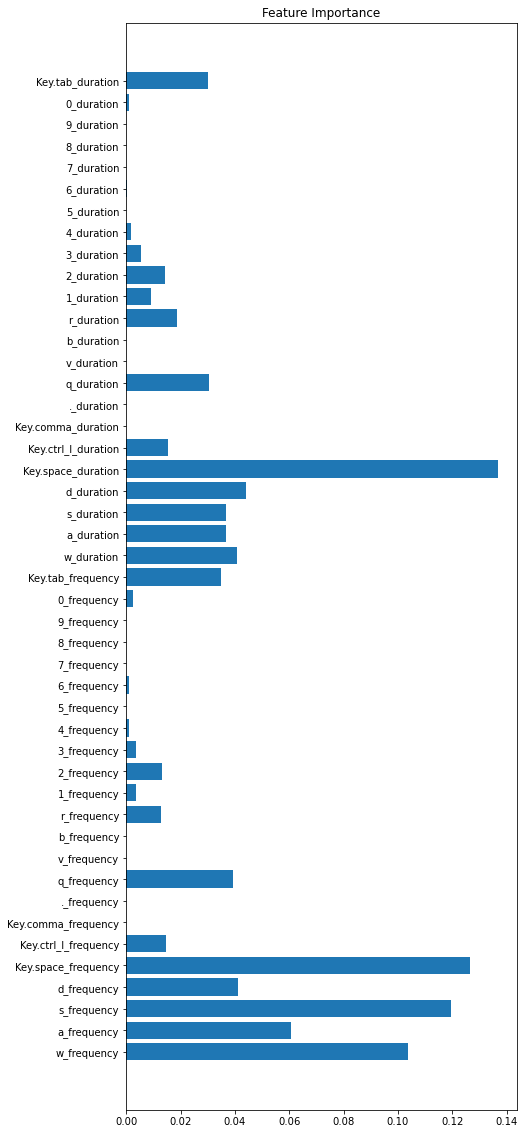

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# We want to plot the feature importance of all features to see how our classifier is splitting data
importances = model.feature_importances_
#indices = np.argsort(importances)

# Expand figure vertically
plt.figure(figsize=(7,20))

# Barplot
plt.barh(range(len(importances)), importances)
# Add feature names as y-axis labels
# replace [indices[i] for i in indices] with feature labels
plt.yticks(range(len(importances)), KeyboardHeatmap.heatmap_data_names())
# Create plot title
plt.title("Feature Importance")
# Show plot
plt.show()

[Text(342.0689655172414, 570.4444444444445, 'Key.space_duration <= 0.231\ngini = 0.115\nsamples = 267\nvalue = [398, 26]'),
 Text(181.72413793103448, 503.3333333333333, 'q_duration <= 0.03\ngini = 0.018\nsamples = 212\nvalue = [335, 3]'),
 Text(160.34482758620692, 436.22222222222223, '1_duration <= 0.05\ngini = 0.024\nsamples = 153\nvalue = [245, 3]'),
 Text(138.9655172413793, 369.1111111111111, 'r_frequency <= 0.005\ngini = 0.028\nsamples = 130\nvalue = [210, 3]'),
 Text(64.13793103448276, 302.0, '4_duration <= 0.04\ngini = 0.013\nsamples = 95\nvalue = [154, 1]'),
 Text(42.758620689655174, 234.88888888888886, 'Key.space_frequency <= 0.3\ngini = 0.014\nsamples = 85\nvalue = [139, 1]'),
 Text(21.379310344827587, 167.77777777777777, 'gini = 0.0\nsamples = 83\nvalue = [138, 0]'),
 Text(64.13793103448276, 167.77777777777777, 's_duration <= 0.765\ngini = 0.5\nsamples = 2\nvalue = [1, 1]'),
 Text(42.758620689655174, 100.66666666666663, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(85.517

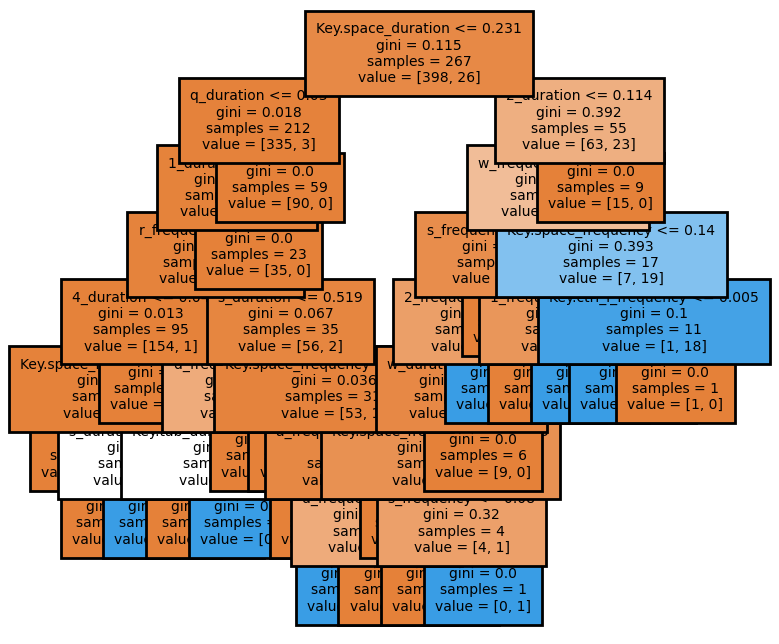

In [6]:
from sklearn import tree

# Plot one tree in our forest for fun
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=200)
tree.plot_tree(rfc.estimators_[0], fontsize=5,feature_names = KeyboardHeatmap.heatmap_data_names(),filled = True)